**Make sure you run this at the begining**

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# Append template path to sys path
sys.path.append(os.getcwd() + "/template") 

In [2]:
from utils.load_data import load_data
from utils.load_data import log
from utils.visualize_tsp import plotTSP
from utils.tsp import TSP
from utils.tsp import TSP_Bench
from utils.tsp import TSP_Bench_ALL

# Workshop Starts Here

<img src="images/tsp.jpg" alt="TSP" style="width: 900px;"/>

<img src="images/solutions.png" alt="solutions" style="width: 900px;"/>

# Get familiar with your dataset

There are problems at different levels. **3 simple, 2 medium, 1 hard**.

In [3]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [4]:
ulysses16 = np.array(load_data("./template/data/simple/ulysses16.tsp"))

In [5]:
ulysses16[:]

array([[38.24, 20.42],
       [39.57, 26.15],
       [40.56, 25.32],
       [36.26, 23.12],
       [33.48, 10.54],
       [37.56, 12.19],
       [38.42, 13.11],
       [37.52, 20.44],
       [41.23,  9.1 ],
       [41.17, 13.05],
       [36.08, -5.21],
       [38.47, 15.13],
       [38.15, 15.35],
       [37.51, 15.17],
       [35.49, 14.32],
       [39.36, 19.56]])

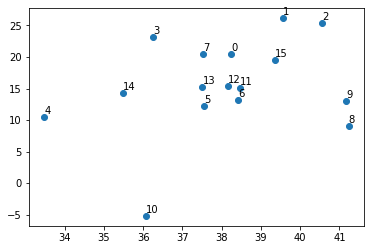

In [6]:
plt.scatter(ulysses16[:, 0], ulysses16[:, 1])
for i in range(0, 16):
    plt.annotate(i, (ulysses16[i, 0], ulysses16[i, 1]+0.5))

## Naive Solution: In Order

In [7]:
simple_sequence = list(range(0, 16))
print(simple_sequence)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


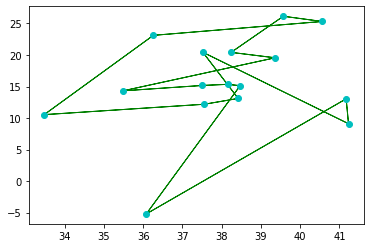

In [8]:
plotTSP([simple_sequence], ulysses16, num_iters=1)

## Naive Solution: Random Permutation

In [9]:
random_permutation = np.random.permutation(16).tolist()
print(random_permutation)

[6, 1, 13, 11, 15, 14, 9, 8, 0, 12, 7, 5, 4, 3, 10, 2]


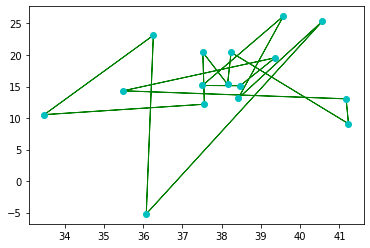

In [10]:
plotTSP([random_permutation], ulysses16, num_iters=1)

## Best Solution

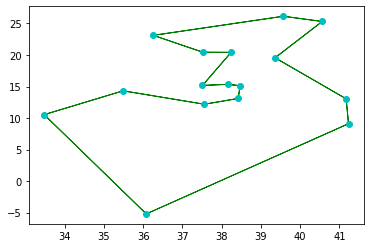

In [11]:
best_ulysses16 = [0, 13, 12, 11, 6, 5, 14, 4, 10, 8, 9, 15, 2, 1, 3, 7]
plotTSP([best_ulysses16], ulysses16, num_iters=1)

## Calculate Fitness (Sum of all Distances)

In [12]:
def dist(node_0, node_1, coords):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = coords[node_0], coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

In [13]:
print("Coordinate of City 0:", ulysses16[0])

Coordinate of City 0: [38.24 20.42]


In [14]:
print("Coordinate of City 1:", ulysses16[1])

Coordinate of City 1: [39.57 26.15]


In [15]:
print("Distance Between", dist(0, 1, ulysses16))

Distance Between 5.882329470541408


In [16]:
def fitness(solution, coords):
    N = len(coords)
    cur_fit = 0
    for i in range(len(solution)):
        cur_fit += dist(solution[i % N], solution[(i + 1) % N], coords)
    return cur_fit

In [17]:
print ("Order Fitness:\t", fitness(simple_sequence, ulysses16))
print ("Random Fitness:\t", fitness(random_permutation, ulysses16))
print ("Best Fitness:\t", fitness(best_ulysses16, ulysses16))

Order Fitness:	 104.42225210207233
Random Fitness:	 165.05253084971622
Best Fitness:	 74.10873595815309


## Naive Random Model

In [18]:
import math
import random
from model.base_model import Model

class MyRandomModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        random_solutions = []
        for i in range(0, max_it):
            solution = np.random.permutation(self.N).tolist()
            random_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = random_solutions[self.fitness_list.index(min(self.fitness_list))]
        return self.best_solution, self.fitness_list

In [19]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [20]:
model = MyRandomModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, max_it=100)

[*] [Node] 16, [Best] 102.73430244116014
[*] Running for: 0.01 seconds



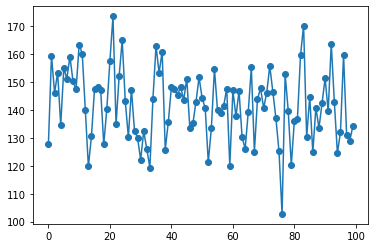

In [21]:
plt.plot(fitness_list, 'o-')

## Simulated Annealing

In [22]:
import math
import random
from model.base_model import Model

class MySAModel(Model):
    def __init__(self):
        super().__init__()

        self.iteration = 0

    def init(self, nodes, *args):
        super().init(nodes)

        T, stopping_temperature, alpha = args

        self.T = math.sqrt(self.N) if T == -1 else T
        self.alpha = 0.995 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_temperature == -1 else stopping_temperature

        self.T_save = self.T  # save inital T to reset if batch annealing is used

    def initial_solution(self):
        """
        Greedy algorithm to get an initial solution (closest-neighbour).
        """
        cur_node = random.choice(self.nodes)  # start from a random node
        solution = [cur_node]

        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.dist(cur_node, x))  # nearest neighbour
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.fitness(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        return solution, cur_fit

    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current.
        Depends on the current temperature and difference between candidate and current.
        """
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current.
        Accept with probabilty p_accept(..) if candidate is worse.
        """
        candidate_fitness = self.fitness(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate

    def fit(self, max_it):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        self.cur_solution, self.cur_fitness = self.initial_solution()

        self.log("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < max_it:
            candidate = list(self.cur_solution)
            l = random.randint(1, self.N - 1)
            i = random.randint(0, self.N - l)
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1

            self.fitness_list.append(self.cur_fitness)

        self.log(f"Best fitness obtained: {self.best_fitness}")
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        self.log(f"Improvement over greedy heuristic: {improvement : .2f}%")

        return self.best_solution, self.fitness_list

In [23]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [24]:
# Set hyper-parameters
T = -1
stopping_T = -1
alpha = 0.99

In [25]:
model = MySAModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, T, stopping_T, alpha, max_it=1000)

[MySAModel] Starting annealing.
[MySAModel] Best fitness obtained: 74.19894280657067
[MySAModel] Improvement over greedy heuristic:  28.71%
[*] [Node] 16, [Best] 74.19894280657067
[*] Running for: 0.02 seconds



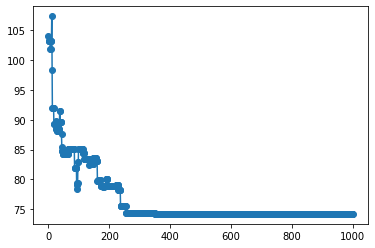

In [26]:
plt.plot(fitness_list, 'o-')

## Your Smart Model

In [27]:
import math
import random
from model.base_model import Model

class MyModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)
        self.log("Nothing to initialize in your model now")

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        self.log("Naive Random Solution")
        self.best_solution = np.random.permutation(self.N).tolist()
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

## Test your Model

In [28]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [29]:
model = MyModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[MyModel] Nothing to initialize in your model now
[MyModel] Naive Random Solution
[*] [Node] 16, [Best] 154.5735310725095
[*] Running for: 0.00 seconds



# Test All Dataset

In [30]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [31]:
def plot_results(best_solutions, times, title):
    fig = plt.figure()
    nodes = [len(s) for s in best_solutions]
    data = np.array([[node, time] for node, time in sorted(zip(nodes, times))])
    plt.plot(data[:, 0], data[:, 1], 'o-')
    fig.suptitle(title, fontsize=20)

In [32]:
tsp_path = './template/data'

In [33]:
model = MyRandomModel()

print("Random Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Random Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 721524.9399929157
[*] Running for: 0.42 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 31159.560032157442
[*] Running for: 0.26 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] [Node] 1000, [Best] 524396404.5171182
[*] Running for: 0.87 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 123105.46532911454
[*] Running for: 0.05 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 103.01947175501947
[*] Running for: 0.02 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 3084.3745918065306
[*] Running for: 0.05 seconds



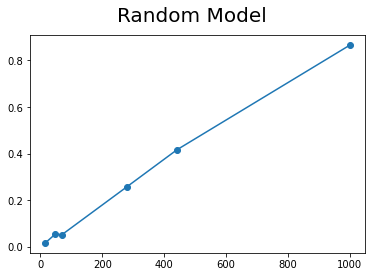

In [34]:
plot_results(best_solutions, times, "Random Model")

In [35]:
# Set hyper-parameters
T = -1
stopping_T = -1
alpha = 0.8

In [36]:
model = MySAModel()

print("Simulated Annealing")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model, T, stopping_T, alpha, max_it=1000)

Simulated Annealing
[*] ./template/data/medium/pcb442.tsp
[MySAModel] Starting annealing.
[MySAModel] Best fitness obtained: 62562.051863573186
[MySAModel] Improvement over greedy heuristic:  0.02%
[*] [Node] 442, [Best] 62562.051863573186
[*] Running for: 0.09 seconds

[*] ./template/data/medium/a280.tsp
[MySAModel] Starting annealing.
[MySAModel] Best fitness obtained: 3398.6263568993063
[MySAModel] Improvement over greedy heuristic:  0.00%
[*] [Node] 280, [Best] 3398.6263568993063
[*] Running for: 0.05 seconds

[*] ./template/data/hard/dsj1000.tsp
[MySAModel] Starting annealing.
[MySAModel] Best fitness obtained: 24551747.27729817
[MySAModel] Improvement over greedy heuristic:  0.00%
[*] [Node] 1000, [Best] 24551747.27729817
[*] Running for: 0.33 seconds

[*] ./template/data/simple/att48.tsp
[MySAModel] Starting annealing.
[MySAModel] Best fitness obtained: 39264.14564540566
[MySAModel] Improvement over greedy heuristic:  1.37%
[*] [Node] 48, [Best] 39264.14564540566
[*] Running for

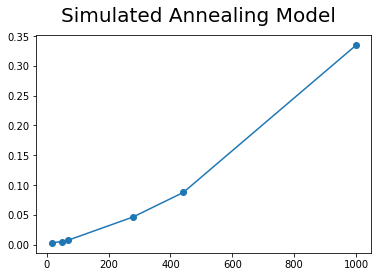

In [37]:
plot_results(best_solutions, times, "Simulated Annealing Model")

# Conclusions